In [56]:
import hifive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pyBigWig

# HiC Heatmap

Finding fend full array for chr13:1000000-120250001... Done


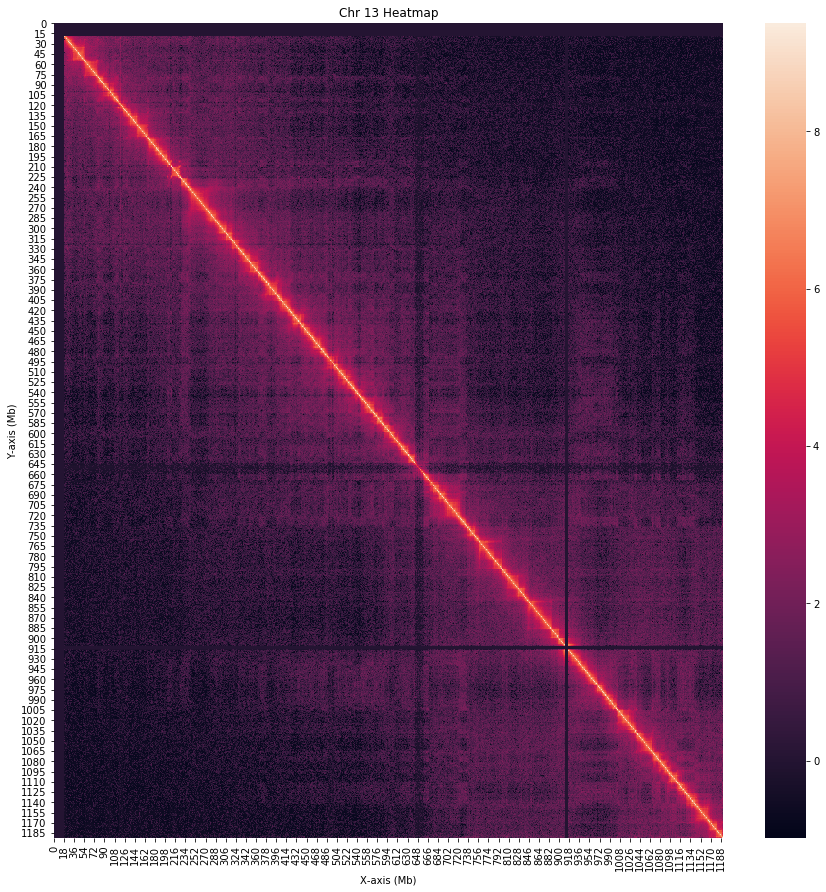

In [61]:
hic=hifive.HiC("project.txt",'r')

#load into array
chr13=hic.cis_heatmap('chr13',1000000,datatype='fend',arraytype='full',diagonalincluded=True)

#correction
enrichment=(chr13[:,:,0]+1)/(chr13[:,:,1]+1)

#log transform
log_enrichment=np.log(enrichment)


fig,ax=plt.subplots(figsize=(15,15))
ax.set_title("Chr 13 Heatmap")
ax=sns.heatmap(log_enrichment)
ax.set_xlabel("X-axis (Mb)")
ax.set_ylabel("Y-axis (Mb)")
plt.savefig("ch13_heatmap.png")

# Compartment Analysis

In [3]:
#produce compartment scores from eigenvector decomposition
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Finding expected full array for chr13:3000000-120300000... Done
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arr

In [14]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

In [15]:
X_start=[x[0] for x in X]

## Compartment score plot

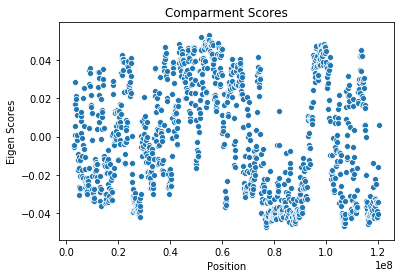

In [62]:
fig,ax=plt.subplots()
sns.scatterplot(X_start,Y)
ax.set_title("Comparment Scores")
ax.set_xlabel("Position")
ax.set_ylabel("Eigen Scores")
plt.savefig("Comparment_scores.png")

## Split up genes

In [65]:
genes=open('data/WT_fpkm.bed')

#create dictionary of genes with length, expression, start and end positions
gene_dict={}
for line in genes:
    field=line.split('\t')
    gene_dict[field[3]]=[int(field[2])-int(field[1]), float(field[4][:-1]), int(field[1]), int(field[2])]

#consolidate gene positions across bins
compa=open('compA_intersect.bed')
a_genes=[]
a_dict={}
for line in compa:
    a=line.split('\t')
    gene=a[3]
    start=int(a[1])
    end=int(a[2])
    if gene in a_dict:
        a_dict[gene]+=end-start
    else:
        a_dict[gene]=end-start
for gene in a_dict: #add genes that exhibit >50% residence in compartment A
    if gene in gene_dict:
        comp=a_dict[gene]
        size=comp/(gene_dict[gene][0])
        if size>0.5:
            a_genes.append([gene,gene_dict[gene][1]])

#do the same with compartment B
compb=open('compB_intersect.bed')
b_genes=[]
b_dict={}
for line in compb:
    b=line.split('\t')
    gene=b[3]
    start=int(b[1])
    end=int(b[2])
    if gene in b_dict:
        b_dict[gene]+=end-start
    else:
        b_dict[gene]=end-start
for gene in b_dict:
    if gene in gene_dict:
        comp=b_dict[gene]
        size=comp/(gene_dict[gene][0])
        if size>0.5:
            b_genes.append([gene,gene_dict[gene][1]])

## Violin plot

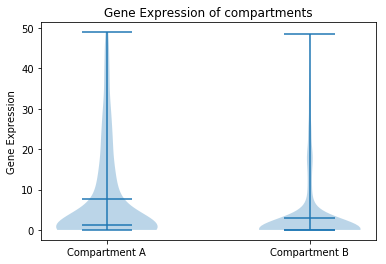

In [71]:
a_expression=[]
b_expression=[]

#limit expression to exclude outliers
for a in a_genes:
    if a[1]<50:
        a_expression.append(a[1])
for b in b_genes:
    if b[1]<50:
        b_expression.append(b[1])

fig, ax = plt.subplots()
ax.violinplot(dataset=[a_expression, b_expression],showmedians=True, showmeans=True)
ax.set_xticks([1,2])
ax.set_xticklabels(["Compartment A","Compartment B"])
ax.set_ylabel("Gene Expression")
ax.set_title("Gene Expression of compartments")
plt.savefig("violinplot.png")

# Expression vs Repression

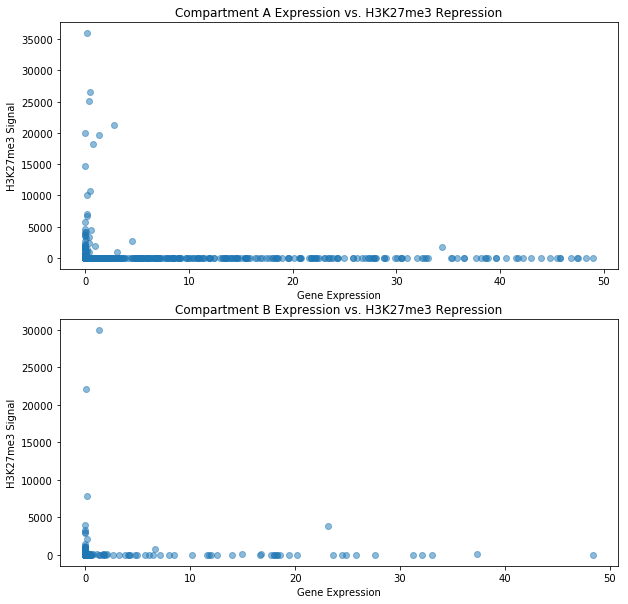

In [84]:
bw = pyBigWig.open('data/WT_H3K27me3.bw')

a_meth=[]
a_exp=[]

#put H3K27me3 signals and expression of genes in compartment A in list
for a in a_genes:
    gene=a[0]
    start=gene_dict[gene][2]
    end=gene_dict[gene][3]
    gene_expression=gene_dict[gene][1]
    if gene_expression<50:
        h3_signal=bw.stats('chr13', start, end, type='sum')
        if h3_signal is None: #replace with 0
            h3_signal=0
        a_meth+=h3_signal
        a_exp.append(gene_expression)

        
b_meth=[]
b_exp=[]

#same for compartment B
for b in b_genes:
    gene=b[0]
    start=gene_dict[gene][2]
    end=gene_dict[gene][3]
    gene_expression=gene_dict[gene][1]
    if gene_expression<50:
        h3_signal=bw.stats('chr13', start, end, type='sum')
        if h3_signal is None: #replace with 0
            h3_signal=0
        b_meth+=h3_signal
        b_exp.append(gene_expression)

#plot
fig,(ax1,ax2) =plt.subplots(2, figsize = (10,10))
ax1.scatter(a_exp,a_meth,alpha=0.5)
ax1.set_title("Compartment A Expression vs. H3K27me3 Repression")
ax1.set_xlabel('Gene Expression')
ax1.set_ylabel("H3K27me3 Signal")

ax2.scatter(b_exp,b_meth,alpha=0.5)
ax2.set_title("Compartment B Expression vs. H3K27me3 Repression")
ax2.set_xlabel('Gene Expression')
ax2.set_ylabel("H3K27me3 Signal")
plt.savefig("expression_vs_repression.png")
